[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Processing files:   0%|                                                                         | 0/39 [00:00<?, ?it/s]The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
`generation_config` default values have been modified to match model-specific defaults: {'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 357, 366, 438, 532, 685, 705, 796, 930, 1058, 1220, 1267, 1279, 1303, 1343, 1377, 1391, 1635, 1782, 1875, 2162, 2361, 2488, 3467, 4008, 4211, 4600, 4808, 5299, 5855, 6329, 7203, 9609, 9959, 10563, 10786, 11420, 11709, 11907, 13163, 13697, 13700, 14808, 15306, 16410, 16791, 17992, 19203, 19510, 


Error Category Analysis:
Shared Errors:
  Count: 30
  Mean Δ log-prob: 0.9318
  Std Δ log-prob: 1.5678

Disappeared Errors:
  Count: 6
  Mean Δ log-prob: -0.5419
  Std Δ log-prob: 3.2258

New Errors:
  Count: 3
  Mean Δ log-prob: 1.9094
  Std Δ log-prob: 0.7817



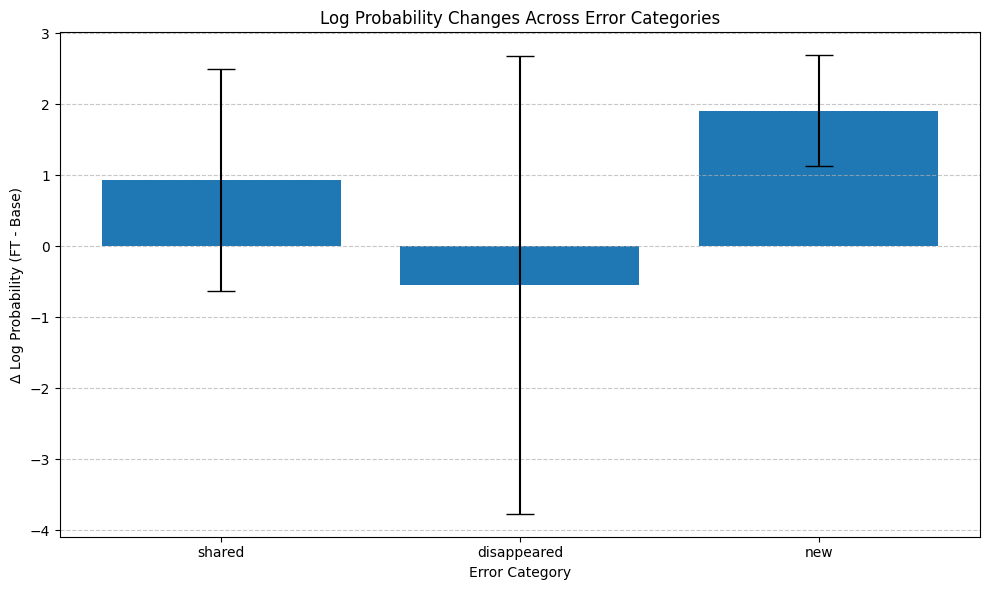

In [1]:
import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import difflib
import nltk
from nltk.corpus import stopwords
import numpy as np

nltk.download('stopwords')

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

stop_words = set(stopwords.words('english'))
supported_formats = (".mp3", ".wav")

# Load models
base_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
base_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base.en")
base_model.eval()

model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()

def transcribe_model(audio_path, model, processor):
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    features = processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    if hasattr(model.generation_config, "forced_decoder_ids"):
        model.generation_config.forced_decoder_ids = None

    with torch.no_grad():
        outputs = model.generate(
            input_features,
            output_scores=True,
            return_dict_in_generate=True,
        )

    predicted_ids = outputs.sequences
    transcription = processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    # Calculate log probabilities for each token
    log_probs = []
    for step, score in enumerate(outputs.scores):
        log_prob = torch.nn.functional.log_softmax(score, dim=-1)
        token_id = predicted_ids[0][step + 1]  # Skip the first token (sos)
        log_probs.append(log_prob[0, token_id].item())

    return transcription, log_probs

def get_word_alignments(ground_truth, hypothesis):
    gt_words = ground_truth.split()
    hyp_words = hypothesis.split()
    
    # Filter out stop words and keep original indices
    filtered_gt = [(i, w) for i, w in enumerate(gt_words) if w.lower() not in stop_words]
    filtered_hyp = [(j, w) for j, w in enumerate(hyp_words) if w.lower() not in stop_words]
    
    # Create lists of just the filtered words for alignment
    gt_filtered_words = [w for _, w in filtered_gt]
    hyp_filtered_words = [w for _, w in filtered_hyp]
    
    matcher = difflib.SequenceMatcher(None, gt_filtered_words, hyp_filtered_words)
    alignments = []
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            for f_gt_idx, f_hyp_idx in zip(range(i1, i2), range(j1, j2)):
                orig_gt_idx = filtered_gt[f_gt_idx][0]
                orig_hyp_idx = filtered_hyp[f_hyp_idx][0]
                alignments.append((orig_gt_idx, orig_hyp_idx, True))
        else:
            # Handle deletions (ground truth words not in hypothesis)
            for f_gt_idx in range(i1, i2):
                orig_gt_idx = filtered_gt[f_gt_idx][0]
                alignments.append((orig_gt_idx, None, False))
            # Handle insertions (hypothesis words not in ground truth)
            for f_hyp_idx in range(j1, j2):
                orig_hyp_idx = filtered_hyp[f_hyp_idx][0]
                alignments.append((None, orig_hyp_idx, False))

    return alignments

def categorize_errors(gt_words, base_words, ft_words):
    # Convert to strings for processing
    gt_str = ' '.join(gt_words)
    base_str = ' '.join(base_words)
    ft_str = ' '.join(ft_words)
    
    # Get alignments ignoring stop words
    base_align = get_word_alignments(gt_str, base_str)
    ft_align = get_word_alignments(gt_str, ft_str)
    
    # Identify content words in ground truth
    content_indices = [i for i, w in enumerate(gt_words) if w.lower() not in stop_words]
    
    error_categories = {
        'shared': [],
        'disappeared': [],
        'new': []
    }
    
    for i in content_indices:
        base_correct = any(a[0] == i and a[2] for a in base_align)
        ft_correct = any(a[0] == i and a[2] for a in ft_align)
        
        if not base_correct and not ft_correct:
            error_categories['shared'].append(i)
        elif not base_correct and ft_correct:
            error_categories['disappeared'].append(i)
        elif base_correct and not ft_correct:
            error_categories['new'].append(i)
    
    return error_categories

def calculate_deltas(error_categories, base_log_probs, ft_log_probs):
    deltas = {
        'shared': [],
        'disappeared': [],
        'new': []
    }
    
    # Helper to find word log probs
    def get_log_probs(word_idx, log_probs):
        if word_idx < len(log_probs):
            return log_probs[word_idx]
        return 0
    
    for idx in error_categories['shared']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['shared'].append(ft_log - base_log)
    
    for idx in error_categories['disappeared']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['disappeared'].append(ft_log - base_log)
    
    for idx in error_categories['new']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['new'].append(ft_log - base_log)
    
    return deltas

def transcribe_with_both_models(audio_dir):
    results = []
    error_deltas = defaultdict(list)
    
    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]
    
    for filename in tqdm(files, desc="Processing files"):
        file_path = os.path.join(audio_dir, filename)
        txt_path = os.path.join(audio_dir, os.path.splitext(filename)[0] + ".txt")
        
        with open(txt_path, 'r') as f:
            ground_truth = f.read().strip()
        
        # Transcribe with both models
        base_text, base_log_probs = transcribe_model(file_path, base_model, base_processor)
        ft_text, ft_log_probs = transcribe_model(file_path, ft_model, ft_processor)
        
        # Transform texts
        gt_processed = transforms(ground_truth)
        base_processed = transforms(base_text)
        ft_processed = transforms(ft_text)
        
        gt_words = gt_processed[0] if isinstance(gt_processed, list) else []
        base_words = base_processed[0] if isinstance(base_processed, list) else []
        ft_words = ft_processed[0] if isinstance(ft_processed, list) else []
        
        # Categorize errors
        error_cats = categorize_errors(gt_words, base_words, ft_words)
        
        # Calculate deltas
        deltas = calculate_deltas(error_cats, base_log_probs, ft_log_probs)
        
        # Aggregate deltas
        for k in deltas:
            error_deltas[k].extend(deltas[k])
        
        # Store results
        results.append({
            'filename': filename,
            'base_text': base_text,
            'ft_text': ft_text,
            'ground_truth': ground_truth,
            'errors': error_cats
        })
    
    return results, error_deltas

def analyze_deltas(error_deltas):
    analysis = {}
    for category, deltas in error_deltas.items():
        if not deltas:
            analysis[category] = {'mean': 0, 'std': 0}
            continue
        analysis[category] = {
            'mean': np.mean(deltas),
            'std': np.std(deltas),
            'count': len(deltas)
        }
    return analysis

# Run analysis
audio_dir = "dataset/a/"
results, error_deltas = transcribe_with_both_models(audio_dir)
analysis = analyze_deltas(error_deltas)

# Print results
print("\nError Category Analysis:")
for category, stats in analysis.items():
    print(f"{category.capitalize()} Errors:")
    print(f"  Count: {stats['count']}")
    print(f"  Mean Δ log-prob: {stats['mean']:.4f}")
    print(f"  Std Δ log-prob: {stats['std']:.4f}\n")

# Visualization
categories = ['shared', 'disappeared', 'new']
means = [analysis[cat]['mean'] for cat in categories]
stds = [analysis[cat]['std'] for cat in categories]

plt.figure(figsize=(10, 6))
plt.bar(categories, means, yerr=stds, capsize=10)
plt.xlabel('Error Category')
plt.ylabel('Δ Log Probability (FT - Base)')
plt.title('Log Probability Changes Across Error Categories')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('delta_log_probs.png')
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Processing files: 100%|████████████████████████████████████████████████████████████████| 51/51 [02:44<00:00,  3.23s/it]



Error Category Analysis:
Shared Errors:
  Count: 26
  Mean Δ log-prob: 0.9584
  Std Δ log-prob: 2.6455

Disappeared Errors:
  Count: 1
  Mean Δ log-prob: 0.5979
  Std Δ log-prob: 0.0000

New Errors:
  Count: 4
  Mean Δ log-prob: -0.0832
  Std Δ log-prob: 0.9673



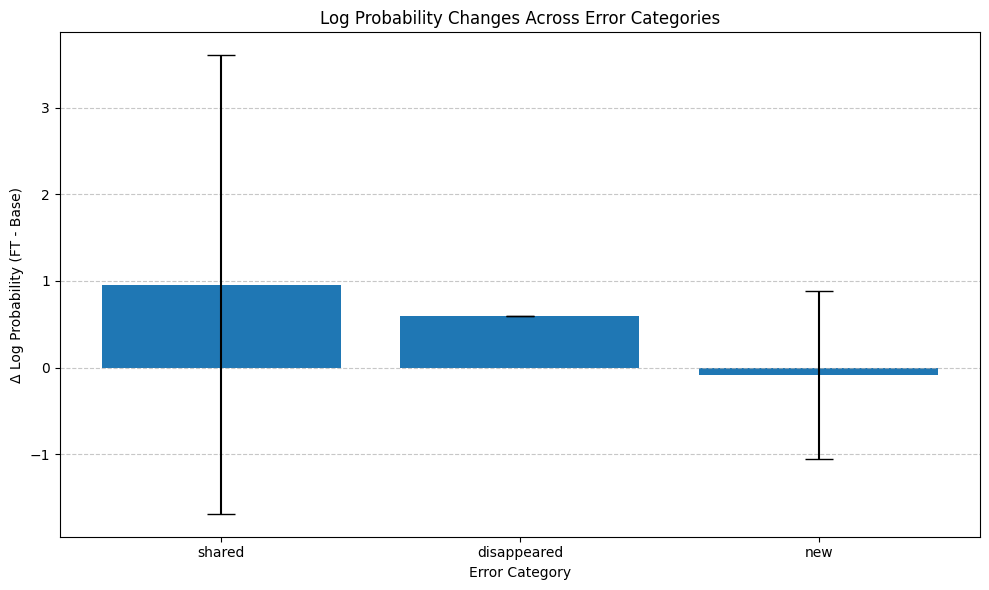

In [2]:
import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import difflib
import nltk
from nltk.corpus import stopwords
import numpy as np

nltk.download('stopwords')

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

stop_words = set(stopwords.words('english'))
supported_formats = (".mp3", ".wav")

# Load models
base_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
base_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base.en")
base_model.eval()

model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()

def transcribe_model(audio_path, model, processor):
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    features = processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    if hasattr(model.generation_config, "forced_decoder_ids"):
        model.generation_config.forced_decoder_ids = None

    with torch.no_grad():
        outputs = model.generate(
            input_features,
            output_scores=True,
            return_dict_in_generate=True,
        )

    predicted_ids = outputs.sequences
    transcription = processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    # Calculate log probabilities for each token
    log_probs = []
    for step, score in enumerate(outputs.scores):
        log_prob = torch.nn.functional.log_softmax(score, dim=-1)
        token_id = predicted_ids[0][step + 1]  # Skip the first token (sos)
        log_probs.append(log_prob[0, token_id].item())

    return transcription, log_probs

def get_word_alignments(ground_truth, hypothesis):
    gt_words = ground_truth.split()
    hyp_words = hypothesis.split()
    
    # Filter out stop words and keep original indices
    filtered_gt = [(i, w) for i, w in enumerate(gt_words) if w.lower() not in stop_words]
    filtered_hyp = [(j, w) for j, w in enumerate(hyp_words) if w.lower() not in stop_words]
    
    # Create lists of just the filtered words for alignment
    gt_filtered_words = [w for _, w in filtered_gt]
    hyp_filtered_words = [w for _, w in filtered_hyp]
    
    matcher = difflib.SequenceMatcher(None, gt_filtered_words, hyp_filtered_words)
    alignments = []
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            for f_gt_idx, f_hyp_idx in zip(range(i1, i2), range(j1, j2)):
                orig_gt_idx = filtered_gt[f_gt_idx][0]
                orig_hyp_idx = filtered_hyp[f_hyp_idx][0]
                alignments.append((orig_gt_idx, orig_hyp_idx, True))
        else:
            # Handle deletions (ground truth words not in hypothesis)
            for f_gt_idx in range(i1, i2):
                orig_gt_idx = filtered_gt[f_gt_idx][0]
                alignments.append((orig_gt_idx, None, False))
            # Handle insertions (hypothesis words not in ground truth)
            for f_hyp_idx in range(j1, j2):
                orig_hyp_idx = filtered_hyp[f_hyp_idx][0]
                alignments.append((None, orig_hyp_idx, False))

    return alignments

def categorize_errors(gt_words, base_words, ft_words):
    # Convert to strings for processing
    gt_str = ' '.join(gt_words)
    base_str = ' '.join(base_words)
    ft_str = ' '.join(ft_words)
    
    # Get alignments ignoring stop words
    base_align = get_word_alignments(gt_str, base_str)
    ft_align = get_word_alignments(gt_str, ft_str)
    
    # Identify content words in ground truth
    content_indices = [i for i, w in enumerate(gt_words) if w.lower() not in stop_words]
    
    error_categories = {
        'shared': [],
        'disappeared': [],
        'new': []
    }
    
    for i in content_indices:
        base_correct = any(a[0] == i and a[2] for a in base_align)
        ft_correct = any(a[0] == i and a[2] for a in ft_align)
        
        if not base_correct and not ft_correct:
            error_categories['shared'].append(i)
        elif not base_correct and ft_correct:
            error_categories['disappeared'].append(i)
        elif base_correct and not ft_correct:
            error_categories['new'].append(i)
    
    return error_categories

def calculate_deltas(error_categories, base_log_probs, ft_log_probs):
    deltas = {
        'shared': [],
        'disappeared': [],
        'new': []
    }
    
    # Helper to find word log probs
    def get_log_probs(word_idx, log_probs):
        if word_idx < len(log_probs):
            return log_probs[word_idx]
        return 0
    
    for idx in error_categories['shared']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['shared'].append(ft_log - base_log)
    
    for idx in error_categories['disappeared']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['disappeared'].append(ft_log - base_log)
    
    for idx in error_categories['new']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['new'].append(ft_log - base_log)
    
    return deltas

def transcribe_with_both_models(audio_dir):
    results = []
    error_deltas = defaultdict(list)
    
    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]
    
    for filename in tqdm(files, desc="Processing files"):
        file_path = os.path.join(audio_dir, filename)
        txt_path = os.path.join(audio_dir, os.path.splitext(filename)[0] + ".txt")
        
        with open(txt_path, 'r') as f:
            ground_truth = f.read().strip()
        
        # Transcribe with both models
        base_text, base_log_probs = transcribe_model(file_path, base_model, base_processor)
        ft_text, ft_log_probs = transcribe_model(file_path, ft_model, ft_processor)
        
        # Transform texts
        gt_processed = transforms(ground_truth)
        base_processed = transforms(base_text)
        ft_processed = transforms(ft_text)
        
        gt_words = gt_processed[0] if isinstance(gt_processed, list) else []
        base_words = base_processed[0] if isinstance(base_processed, list) else []
        ft_words = ft_processed[0] if isinstance(ft_processed, list) else []
        
        # Categorize errors
        error_cats = categorize_errors(gt_words, base_words, ft_words)
        
        # Calculate deltas
        deltas = calculate_deltas(error_cats, base_log_probs, ft_log_probs)
        
        # Aggregate deltas
        for k in deltas:
            error_deltas[k].extend(deltas[k])
        
        # Store results
        results.append({
            'filename': filename,
            'base_text': base_text,
            'ft_text': ft_text,
            'ground_truth': ground_truth,
            'errors': error_cats
        })
    
    return results, error_deltas

def analyze_deltas(error_deltas):
    analysis = {}
    for category, deltas in error_deltas.items():
        if not deltas:
            analysis[category] = {'mean': 0, 'std': 0}
            continue
        analysis[category] = {
            'mean': np.mean(deltas),
            'std': np.std(deltas),
            'count': len(deltas)
        }
    return analysis

# Run analysis
audio_dir = "dataset/b/"
results, error_deltas = transcribe_with_both_models(audio_dir)
analysis = analyze_deltas(error_deltas)

# Print results
print("\nError Category Analysis:")
for category, stats in analysis.items():
    print(f"{category.capitalize()} Errors:")
    print(f"  Count: {stats['count']}")
    print(f"  Mean Δ log-prob: {stats['mean']:.4f}")
    print(f"  Std Δ log-prob: {stats['std']:.4f}\n")

# Visualization
categories = ['shared', 'disappeared', 'new']
means = [analysis[cat]['mean'] for cat in categories]
stds = [analysis[cat]['std'] for cat in categories]

plt.figure(figsize=(10, 6))
plt.bar(categories, means, yerr=stds, capsize=10)
plt.xlabel('Error Category')
plt.ylabel('Δ Log Probability (FT - Base)')
plt.title('Log Probability Changes Across Error Categories')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('delta_log_probs.png')
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Processing files: 100%|████████████████████████████████████████████████████████████████| 32/32 [01:59<00:00,  3.72s/it]



Error Category Analysis:
Shared Errors:
  Count: 25
  Mean Δ log-prob: 0.4240
  Std Δ log-prob: 0.7032

Disappeared Errors:
  Count: 6
  Mean Δ log-prob: 1.4805
  Std Δ log-prob: 1.2342

New Errors:
  Count: 2
  Mean Δ log-prob: -2.4345
  Std Δ log-prob: 2.5892



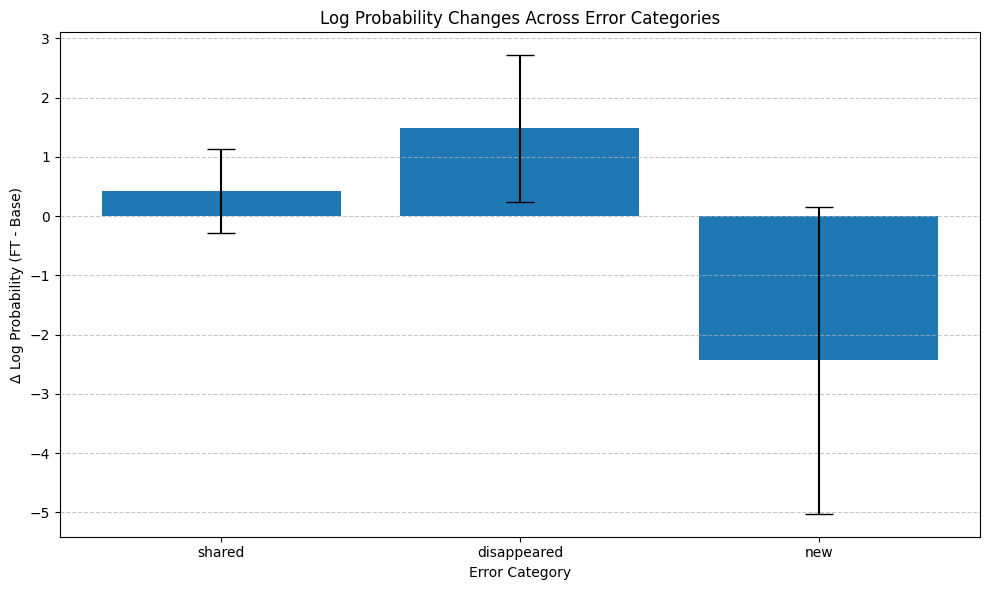

In [3]:
import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import difflib
import nltk
from nltk.corpus import stopwords
import numpy as np

nltk.download('stopwords')

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

stop_words = set(stopwords.words('english'))
supported_formats = (".mp3", ".wav")

# Load models
base_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
base_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base.en")
base_model.eval()

model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()

def transcribe_model(audio_path, model, processor):
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    features = processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    if hasattr(model.generation_config, "forced_decoder_ids"):
        model.generation_config.forced_decoder_ids = None

    with torch.no_grad():
        outputs = model.generate(
            input_features,
            output_scores=True,
            return_dict_in_generate=True,
        )

    predicted_ids = outputs.sequences
    transcription = processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    # Calculate log probabilities for each token
    log_probs = []
    for step, score in enumerate(outputs.scores):
        log_prob = torch.nn.functional.log_softmax(score, dim=-1)
        token_id = predicted_ids[0][step + 1]  # Skip the first token (sos)
        log_probs.append(log_prob[0, token_id].item())

    return transcription, log_probs

def get_word_alignments(ground_truth, hypothesis):
    gt_words = ground_truth.split()
    hyp_words = hypothesis.split()
    
    # Filter out stop words and keep original indices
    filtered_gt = [(i, w) for i, w in enumerate(gt_words) if w.lower() not in stop_words]
    filtered_hyp = [(j, w) for j, w in enumerate(hyp_words) if w.lower() not in stop_words]
    
    # Create lists of just the filtered words for alignment
    gt_filtered_words = [w for _, w in filtered_gt]
    hyp_filtered_words = [w for _, w in filtered_hyp]
    
    matcher = difflib.SequenceMatcher(None, gt_filtered_words, hyp_filtered_words)
    alignments = []
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            for f_gt_idx, f_hyp_idx in zip(range(i1, i2), range(j1, j2)):
                orig_gt_idx = filtered_gt[f_gt_idx][0]
                orig_hyp_idx = filtered_hyp[f_hyp_idx][0]
                alignments.append((orig_gt_idx, orig_hyp_idx, True))
        else:
            # Handle deletions (ground truth words not in hypothesis)
            for f_gt_idx in range(i1, i2):
                orig_gt_idx = filtered_gt[f_gt_idx][0]
                alignments.append((orig_gt_idx, None, False))
            # Handle insertions (hypothesis words not in ground truth)
            for f_hyp_idx in range(j1, j2):
                orig_hyp_idx = filtered_hyp[f_hyp_idx][0]
                alignments.append((None, orig_hyp_idx, False))

    return alignments

def categorize_errors(gt_words, base_words, ft_words):
    # Convert to strings for processing
    gt_str = ' '.join(gt_words)
    base_str = ' '.join(base_words)
    ft_str = ' '.join(ft_words)
    
    # Get alignments ignoring stop words
    base_align = get_word_alignments(gt_str, base_str)
    ft_align = get_word_alignments(gt_str, ft_str)
    
    # Identify content words in ground truth
    content_indices = [i for i, w in enumerate(gt_words) if w.lower() not in stop_words]
    
    error_categories = {
        'shared': [],
        'disappeared': [],
        'new': []
    }
    
    for i in content_indices:
        base_correct = any(a[0] == i and a[2] for a in base_align)
        ft_correct = any(a[0] == i and a[2] for a in ft_align)
        
        if not base_correct and not ft_correct:
            error_categories['shared'].append(i)
        elif not base_correct and ft_correct:
            error_categories['disappeared'].append(i)
        elif base_correct and not ft_correct:
            error_categories['new'].append(i)
    
    return error_categories

def calculate_deltas(error_categories, base_log_probs, ft_log_probs):
    deltas = {
        'shared': [],
        'disappeared': [],
        'new': []
    }
    
    # Helper to find word log probs
    def get_log_probs(word_idx, log_probs):
        if word_idx < len(log_probs):
            return log_probs[word_idx]
        return 0
    
    for idx in error_categories['shared']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['shared'].append(ft_log - base_log)
    
    for idx in error_categories['disappeared']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['disappeared'].append(ft_log - base_log)
    
    for idx in error_categories['new']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['new'].append(ft_log - base_log)
    
    return deltas

def transcribe_with_both_models(audio_dir):
    results = []
    error_deltas = defaultdict(list)
    
    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]
    
    for filename in tqdm(files, desc="Processing files"):
        file_path = os.path.join(audio_dir, filename)
        txt_path = os.path.join(audio_dir, os.path.splitext(filename)[0] + ".txt")
        
        with open(txt_path, 'r') as f:
            ground_truth = f.read().strip()
        
        # Transcribe with both models
        base_text, base_log_probs = transcribe_model(file_path, base_model, base_processor)
        ft_text, ft_log_probs = transcribe_model(file_path, ft_model, ft_processor)
        
        # Transform texts
        gt_processed = transforms(ground_truth)
        base_processed = transforms(base_text)
        ft_processed = transforms(ft_text)
        
        gt_words = gt_processed[0] if isinstance(gt_processed, list) else []
        base_words = base_processed[0] if isinstance(base_processed, list) else []
        ft_words = ft_processed[0] if isinstance(ft_processed, list) else []
        
        # Categorize errors
        error_cats = categorize_errors(gt_words, base_words, ft_words)
        
        # Calculate deltas
        deltas = calculate_deltas(error_cats, base_log_probs, ft_log_probs)
        
        # Aggregate deltas
        for k in deltas:
            error_deltas[k].extend(deltas[k])
        
        # Store results
        results.append({
            'filename': filename,
            'base_text': base_text,
            'ft_text': ft_text,
            'ground_truth': ground_truth,
            'errors': error_cats
        })
    
    return results, error_deltas

def analyze_deltas(error_deltas):
    analysis = {}
    for category, deltas in error_deltas.items():
        if not deltas:
            analysis[category] = {'mean': 0, 'std': 0}
            continue
        analysis[category] = {
            'mean': np.mean(deltas),
            'std': np.std(deltas),
            'count': len(deltas)
        }
    return analysis

# Run analysis
audio_dir = "dataset/c/"
results, error_deltas = transcribe_with_both_models(audio_dir)
analysis = analyze_deltas(error_deltas)

# Print results
print("\nError Category Analysis:")
for category, stats in analysis.items():
    print(f"{category.capitalize()} Errors:")
    print(f"  Count: {stats['count']}")
    print(f"  Mean Δ log-prob: {stats['mean']:.4f}")
    print(f"  Std Δ log-prob: {stats['std']:.4f}\n")

# Visualization
categories = ['shared', 'disappeared', 'new']
means = [analysis[cat]['mean'] for cat in categories]
stds = [analysis[cat]['std'] for cat in categories]

plt.figure(figsize=(10, 6))
plt.bar(categories, means, yerr=stds, capsize=10)
plt.xlabel('Error Category')
plt.ylabel('Δ Log Probability (FT - Base)')
plt.title('Log Probability Changes Across Error Categories')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('delta_log_probs.png')
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Processing files: 100%|████████████████████████████████████████████████████████████████| 66/66 [02:54<00:00,  2.64s/it]



Error Category Analysis:
Shared Errors:
  Count: 61
  Mean Δ log-prob: 0.8955
  Std Δ log-prob: 1.4675

Disappeared Errors:
  Count: 0
  Mean Δ log-prob: 0.0000
  Std Δ log-prob: 0.0000

New Errors:
  Count: 5
  Mean Δ log-prob: 0.8618
  Std Δ log-prob: 1.8443



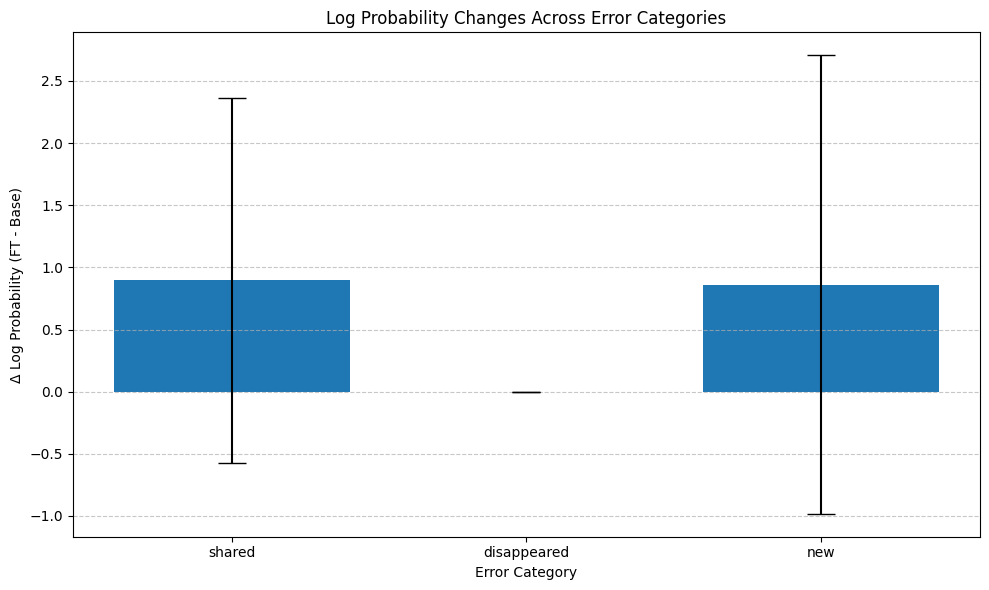

In [6]:
import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import difflib
import nltk
from nltk.corpus import stopwords
import numpy as np

nltk.download('stopwords')

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

stop_words = set(stopwords.words('english'))
supported_formats = (".mp3", ".wav")

# Load models
base_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
base_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base.en")
base_model.eval()

model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()

def transcribe_model(audio_path, model, processor):
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    features = processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    if hasattr(model.generation_config, "forced_decoder_ids"):
        model.generation_config.forced_decoder_ids = None

    with torch.no_grad():
        outputs = model.generate(
            input_features,
            output_scores=True,
            return_dict_in_generate=True,
        )

    predicted_ids = outputs.sequences
    transcription = processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    # Calculate log probabilities for each token
    log_probs = []
    for step, score in enumerate(outputs.scores):
        log_prob = torch.nn.functional.log_softmax(score, dim=-1)
        token_id = predicted_ids[0][step + 1]  # Skip the first token (sos)
        log_probs.append(log_prob[0, token_id].item())

    return transcription, log_probs

def get_word_alignments(ground_truth, hypothesis):
    gt_words = ground_truth.split()
    hyp_words = hypothesis.split()
    
    # Filter out stop words and keep original indices
    filtered_gt = [(i, w) for i, w in enumerate(gt_words) if w.lower() not in stop_words]
    filtered_hyp = [(j, w) for j, w in enumerate(hyp_words) if w.lower() not in stop_words]
    
    # Create lists of just the filtered words for alignment
    gt_filtered_words = [w for _, w in filtered_gt]
    hyp_filtered_words = [w for _, w in filtered_hyp]
    
    matcher = difflib.SequenceMatcher(None, gt_filtered_words, hyp_filtered_words)
    alignments = []
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            for f_gt_idx, f_hyp_idx in zip(range(i1, i2), range(j1, j2)):
                orig_gt_idx = filtered_gt[f_gt_idx][0]
                orig_hyp_idx = filtered_hyp[f_hyp_idx][0]
                alignments.append((orig_gt_idx, orig_hyp_idx, True))
        else:
            # Handle deletions (ground truth words not in hypothesis)
            for f_gt_idx in range(i1, i2):
                orig_gt_idx = filtered_gt[f_gt_idx][0]
                alignments.append((orig_gt_idx, None, False))
            # Handle insertions (hypothesis words not in ground truth)
            for f_hyp_idx in range(j1, j2):
                orig_hyp_idx = filtered_hyp[f_hyp_idx][0]
                alignments.append((None, orig_hyp_idx, False))

    return alignments

def categorize_errors(gt_words, base_words, ft_words):
    # Convert to strings for processing
    gt_str = ' '.join(gt_words)
    base_str = ' '.join(base_words)
    ft_str = ' '.join(ft_words)
    
    # Get alignments ignoring stop words
    base_align = get_word_alignments(gt_str, base_str)
    ft_align = get_word_alignments(gt_str, ft_str)
    
    # Identify content words in ground truth
    content_indices = [i for i, w in enumerate(gt_words) if w.lower() not in stop_words]
    
    error_categories = {
        'shared': [],
        'disappeared': [],
        'new': []
    }
    
    for i in content_indices:
        base_correct = any(a[0] == i and a[2] for a in base_align)
        ft_correct = any(a[0] == i and a[2] for a in ft_align)
        
        if not base_correct and not ft_correct:
            error_categories['shared'].append(i)
        elif not base_correct and ft_correct:
            error_categories['disappeared'].append(i)
        elif base_correct and not ft_correct:
            error_categories['new'].append(i)
    
    return error_categories

def calculate_deltas(error_categories, base_log_probs, ft_log_probs):
    deltas = {
        'shared': [],
        'disappeared': [],
        'new': []
    }
    
    # Helper to find word log probs
    def get_log_probs(word_idx, log_probs):
        if word_idx < len(log_probs):
            return log_probs[word_idx]
        return 0
    
    for idx in error_categories['shared']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['shared'].append(ft_log - base_log)
    
    for idx in error_categories['disappeared']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['disappeared'].append(ft_log - base_log)
    
    for idx in error_categories['new']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['new'].append(ft_log - base_log)
    
    return deltas

def transcribe_with_both_models(audio_dir):
    results = []
    error_deltas = defaultdict(list)
    
    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]
    
    for filename in tqdm(files, desc="Processing files"):
        file_path = os.path.join(audio_dir, filename)
        txt_path = os.path.join(audio_dir, os.path.splitext(filename)[0] + ".txt")
        
        with open(txt_path, 'r') as f:
            ground_truth = f.read().strip()
        
        # Transcribe with both models
        base_text, base_log_probs = transcribe_model(file_path, base_model, base_processor)
        ft_text, ft_log_probs = transcribe_model(file_path, ft_model, ft_processor)
        
        # Transform texts
        gt_processed = transforms(ground_truth)
        base_processed = transforms(base_text)
        ft_processed = transforms(ft_text)
        
        gt_words = gt_processed[0] if isinstance(gt_processed, list) else []
        base_words = base_processed[0] if isinstance(base_processed, list) else []
        ft_words = ft_processed[0] if isinstance(ft_processed, list) else []
        
        # Categorize errors
        error_cats = categorize_errors(gt_words, base_words, ft_words)
        
        # Calculate deltas
        deltas = calculate_deltas(error_cats, base_log_probs, ft_log_probs)
        
        # Aggregate deltas
        for k in deltas:
            error_deltas[k].extend(deltas[k])
        
        # Store results
        results.append({
            'filename': filename,
            'base_text': base_text,
            'ft_text': ft_text,
            'ground_truth': ground_truth,
            'errors': error_cats
        })
    
    return results, error_deltas

def analyze_deltas(error_deltas):
    analysis = {}
    for category, deltas in error_deltas.items():
        if not deltas:
            analysis[category] = {'mean': 0, 'std': 0, 'count': 0}
            continue
        analysis[category] = {
            'mean': np.mean(deltas),
            'std': np.std(deltas),
            'count': len(deltas)
        }
    return analysis

# Run analysis
audio_dir = "dataset/d/"
results, error_deltas = transcribe_with_both_models(audio_dir)
analysis = analyze_deltas(error_deltas)

# Print results
print("\nError Category Analysis:")
for category, stats in analysis.items():
    print(f"{category.capitalize()} Errors:")
    print(f"  Count: {stats['count']}")
    print(f"  Mean Δ log-prob: {stats['mean']:.4f}")
    print(f"  Std Δ log-prob: {stats['std']:.4f}\n")

# Visualization
categories = ['shared', 'disappeared', 'new']
means = [analysis[cat]['mean'] for cat in categories]
stds = [analysis[cat]['std'] for cat in categories]

plt.figure(figsize=(10, 6))
plt.bar(categories, means, yerr=stds, capsize=10)
plt.xlabel('Error Category')
plt.ylabel('Δ Log Probability (FT - Base)')
plt.title('Log Probability Changes Across Error Categories')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('delta_log_probs.png')
plt.show()